# Comparison Example

In this notebook, we show some examples of comparisons between simulations of theoretical models and experimental data. This aspect of the NeuralPlayground (NPG) software is still under development. With time, we want to implement tools exclusively made to compare simulated and experimental data, such as a GUI to quickly navigate through the results, add useful metrics to measure the performance of agents or similarity between neural representation, and a "simulation manager" to keep track of the state of all of your runs and available results. For now, this notebook uses the three main modules of NPG, "experiments", "arenas" and "agents", to simulate theoretical models and compare with what is seen in neural recording from real experiments.

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [11]:
import sys
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from neuralplayground.arenas import Wernle2018, MergingRoom, Sargolini2006
from neuralplayground.agents import Weber2018, Stachenfeld2018
from neuralplayground.experiments import Wernle2018Data

In [12]:
env = Sargolini2006(use_behavioral_data=True,
                    time_step_size=0.1,
                    agent_step_size=None)

In [13]:
agent_step_size = 10
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode = 1000
n_episode = 100
state_density = (1 / agent_step_size)
twoDvalue = True

agent = Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density, twoD=twoDvalue)


array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

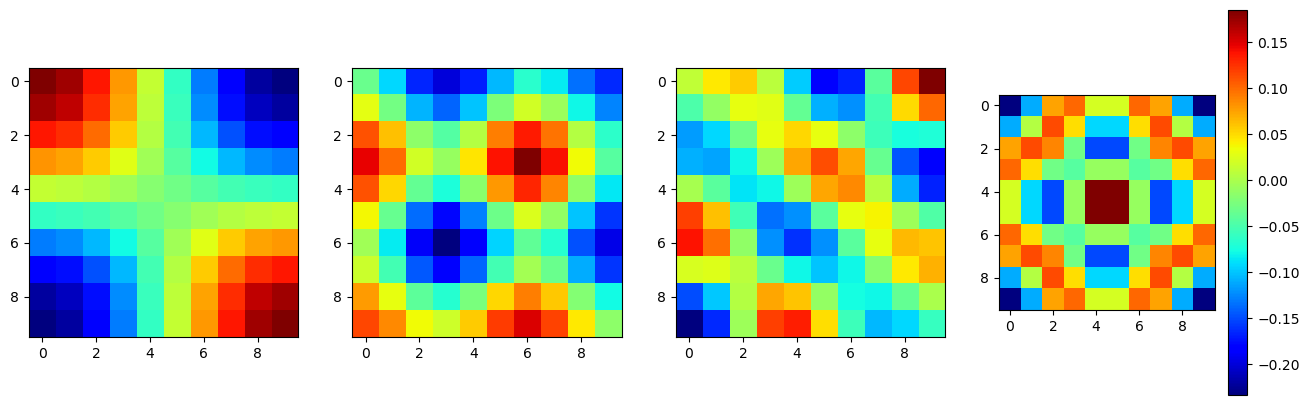

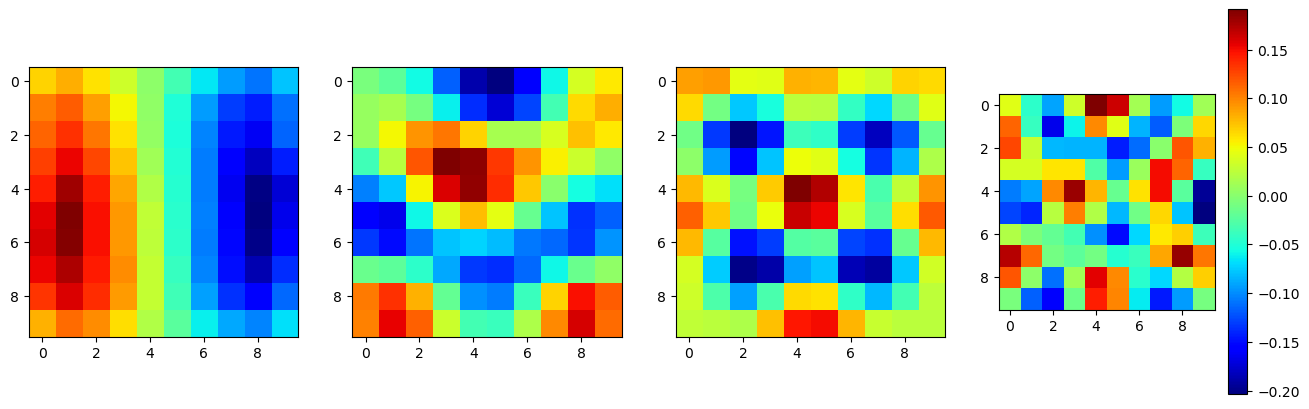

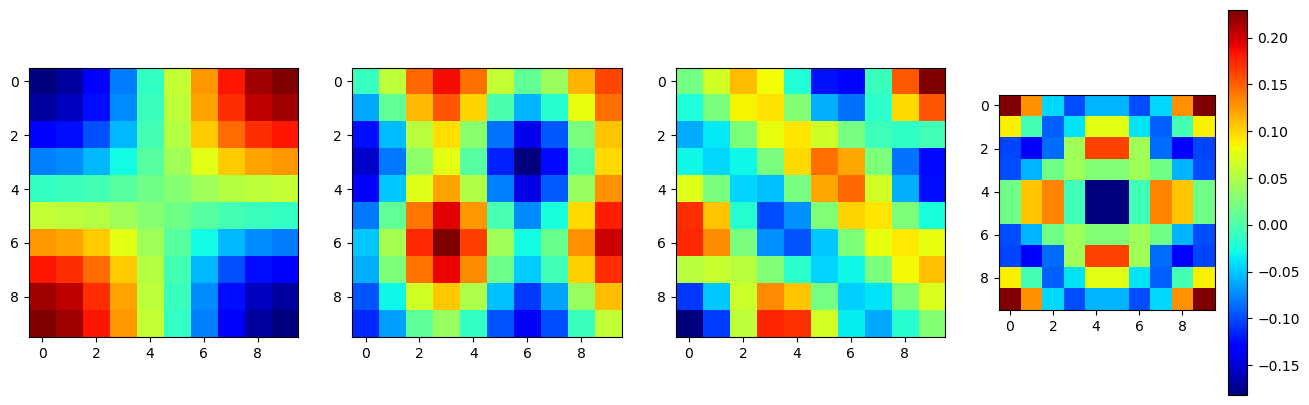

In [14]:
sr = agent.update_successor_rep() # One can compute the successor representation using successive additive update

agent.plot_eigen(sr,eigen=[1,10,15,20], save_path=None)

sr_td = agent.update_successor_rep_td_full() # Compute the successor representation matrix using TD learning
agent.plot_eigen(sr_td, eigen=[1,10,15,20],save_path=None)

sr_sum = agent.successor_rep_sum() # One can compute the successor representation matrix using geometric sums for $\gamma<1$
agent.plot_eigen(sr_sum, eigen=[1,10,15,20],save_path=None)


In [24]:
env.show_data()

Dataframe with recordings


,rat_id,session,recorded_vars
rec_index,,,
0,11016,02020502,"[T5C1, T7C1, EEG, EGF, position]"
1,11016,25010501,"[T6C2, EEG, EGF, position]"
2,11016,28010501,"[T1C2, EEG, EGF, position]"
3,11016,29010503,"[T5C1, T6C1, T6C2, T7C1, EEG, EGF, position]"
4,11016,31010502,"[T5C2, T6C1, T6C2, T6C3, T8C2, EEG, EGF, posit..."


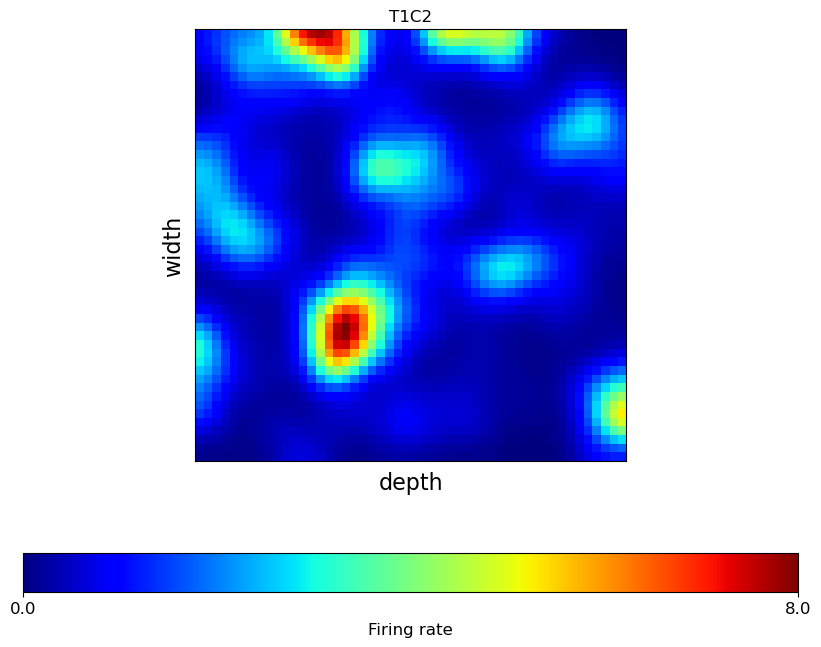

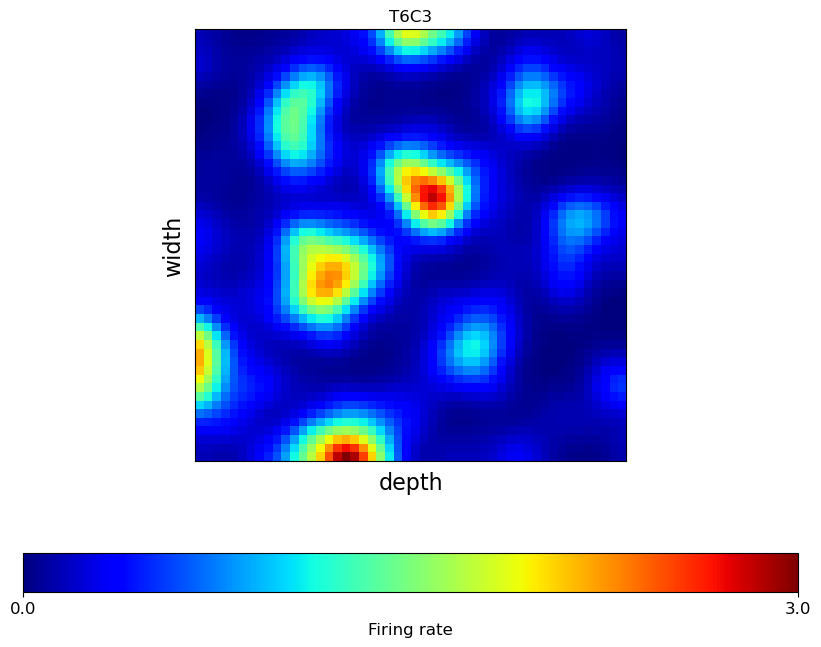

In [29]:
list_of_cells = env.plot_recording_tetr(recording_index = [2, 4], tetrode_id = ["T1C2", "T6C3"])

In [31]:
time_step_size = 0.2
merging_time = 270*2.0  # Time in minutes to remove 
switch_time = 270.0 # Time in minutes to move the mouse to the other side of the arena
additional_time = 270.0

n_steps = ((merging_time + switch_time + additional_time)*60) / time_step_size
fontsize = 16

room_width = [-10,10]
room_depth = [-10,10]
env_name = "merging_room"

# Init environment
env = MergingRoom(arena_x_limits = room_width,
                  arena_y_limits = room_depth,
                  time_step_size = time_step_size,
                  agent_step_size = agent_step_size,
                  merge_time = merging_time,
                  switch_time = switch_time)

print(n_steps)
print(int((merging_time*60)/time_step_size))
print(int((switch_time*60)/time_step_size))

324000.0
162000
81000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9800/9800 [00:04<00:00, 2142.30it/s]


array([<AxesSubplot: title={'center': 'Exc rates'}>,
       <AxesSubplot: title={'center': 'Inh rates'}>,
       <AxesSubplot: title={'center': 'Out rate'}>], dtype=object)

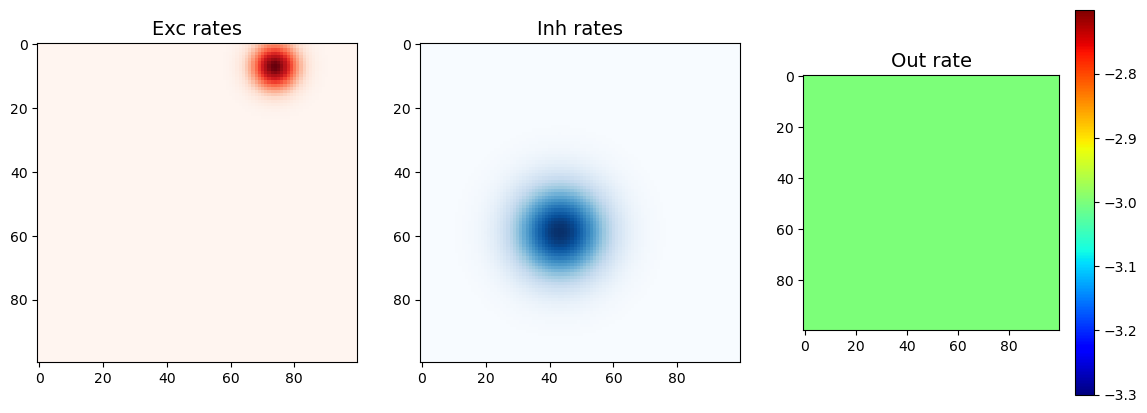

In [33]:
exc_eta = 1.3e-4
inh_eta = 5.3e-4
model_name = "model_example"
sigma_exc = np.array([0.05, 0.05])
sigma_inh = np.array([0.1, 0.1])
Ne = 2*4900
Ni = 2*1225
Nef = 1
Nif = 1
alpha_i = 1
alpha_e = 1
we_init = 1.0
wi_init = 1.51
agent_step_size = 1.0
agent = Weber2018(model_name=model_name, exc_eta=exc_eta, inh_eta=inh_eta, sigma_exc=sigma_exc,
                  sigma_inh=sigma_inh, Ne=Ne, Ni=Ni, agent_step_size=agent_step_size, ro=1,
                  Nef=Nef, Nif=Nif, room_width=env.room_width, room_depth=env.room_depth,
                  alpha_i=alpha_i, alpha_e=alpha_e, we_init=we_init, wi_init=wi_init)

agent.plot_rates()

In [ ]:
obs, state = env.reset()

for j in tqdm(range(round(n_steps))):
    # Observe to choose an action
    action = agent.act(obs)
    # Run environment for given action
    obs, state, reward = env.step(action)
    agent.update()
    # We plot the trajectory of the agent just right before switching and before merging
    # then we keep running the loop
    if j == int((switch_time*60)/time_step_size)-1:
        # plot trajectory
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=fontsize)
        ax.set_ylabel("depth", fontsize=fontsize)
        # If you like, you can save the current state of the agent using the save_agent method to load the agent later
        # agent.save_agent("pre_switch.agent")
        # plot rates
        agent.plot_rates()
        plt.savefig("pre_switch.pdf", bbox_inches="tight")
    if j == int((merging_time*60)/time_step_size)-1:
        # Same thing, plotting just before the merging of the rooms
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=fontsize)
        ax.set_ylabel("depth", fontsize=fontsize)
        agent.plot_rates()
        plt.savefig("pre_merge.pdf", bbox_inches="tight")
        # agent.save_agent("pre_merge.agent")

# Use the line below to save the agent and use it later        
# agent.save_agent("post_merge.agent")

  0%|          | 0/324000 [00:00<?, ?it/s]

In [ ]:
# Here we take the section of interaction history for the period after the merge
merged_history = env.history[int((merging_time*60)/time_step_size):]
# Note that the wall is already removed from the arena structure
ax = env.plot_trajectory(history_data=merged_history, plot_every=100)
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)

agent.plot_rates()
plt.savefig("post_merge.pdf", bbox_inches="tight")

In [ ]:
w_data = Wernle2018Data()

In [ ]:
recording_list = w_data.show_data(full_dataframe=False)

In [ ]:
rates = w_data.plot_merging_comparison(session_index=(100, 125, 126, 127))